In [2]:
import numpy as np
import math
import glob
import peakutils
import scipy
from scipy.stats import norm
from scipy.fftpack import fft, rfft, fftshift
import matplotlib.pyplot as plt
import matplotlib
import sys
import tqdm

sys.path.append('/home/jianwei_leejw/scripts/TESPulseFitCode')
import lecroy
import heralded_pulses_analysis as hpa

# Fast FT
returns positive and negative frequency comps

In [3]:
def FFT(time,signal):
    """
    returns and plots fft for a time series
    """
    dt = time[1]-time[0]
    N = len(time)
    fft_abs = abs(np.fft.rfft(signal))
    fft_norm = np.sum(abs(fft_abs))
    prob = fft_abs/fft_norm
    freq = np.fft.rfftfreq(signal.size, dt)
    
    return freq, prob

<IPython.core.display.Javascript object>


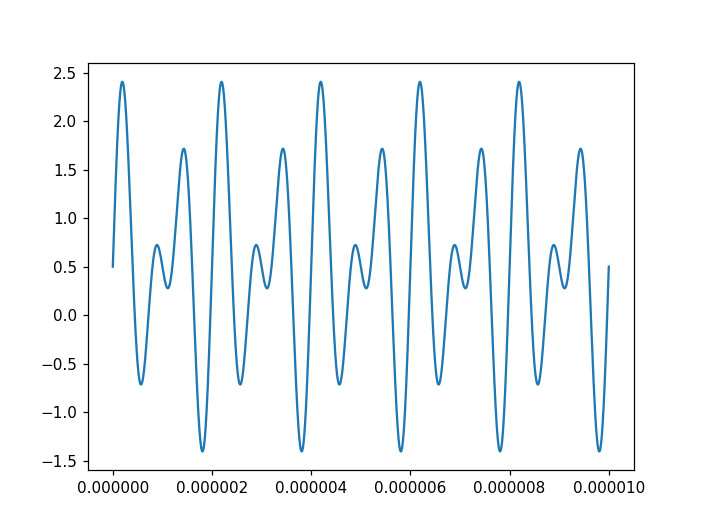

In [4]:
# test data set @ 1MHz
time = np.arange(0, 10.001e-6, 0.001e-6)
signal = 0.5+np.sin(2*math.pi*1e6*time)+np.sin(2*math.pi*1.5e6*time)
# signal=np.ones(len(time))
%matplotlib notebook
plt.figure()
plt.plot(time,signal)

<IPython.core.display.Javascript object>


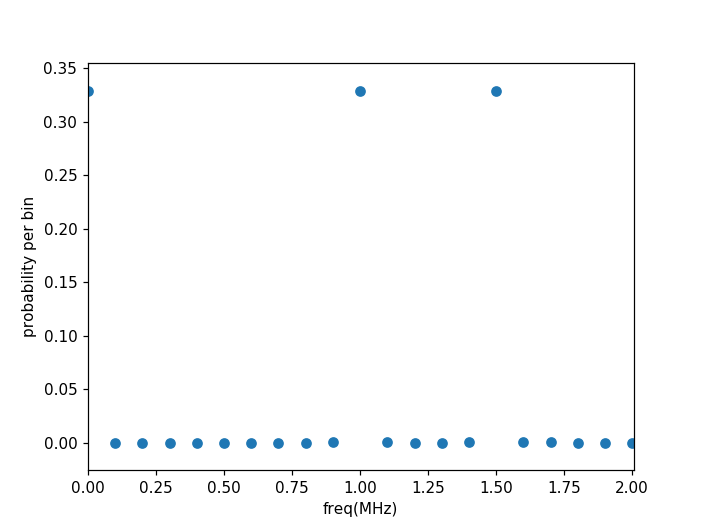

(0, 2.005)

In [5]:
freq, prob = FFT(time, signal)
plt.figure()
plt.scatter(freq/1e6,prob)
plt.xlabel('freq(MHz)')
plt.ylabel('probability per bin')
plt.xlim(0,2.005)

In [16]:
# import noise spectrum
bg_init_folder = '/workspace/projects/TES/data/20170523_TES5_75mK_95uA_trise_115ns/bg_init/'
bg_filelist = glob.glob(bg_init_folder+'*.trc')
t, s = hpa.trace_extr(bg_filelist[0])

<IPython.core.display.Javascript object>


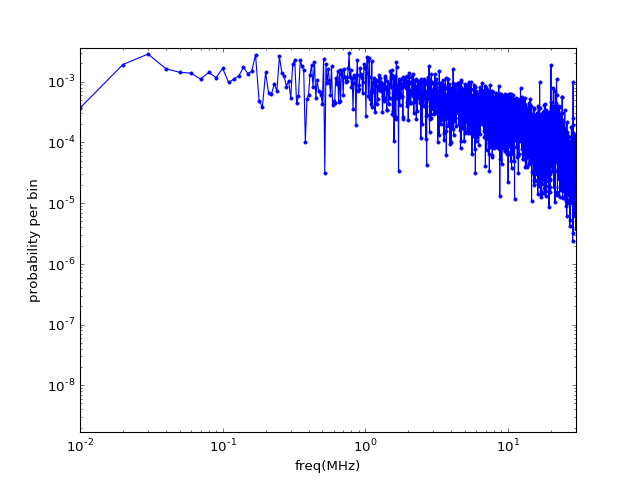

(1.6946285201033368e-09, 0.003592905166214961)

In [40]:
freq, prob = FFT(t, s)
plt.figure()
plt.loglog(freq/1e6,prob,marker='.')
plt.xlabel('freq(MHz)')
plt.ylabel('probability per bin')
plt.xlim(0,30)
plt.ylim(0,np.max(prob)*1.2)

In [107]:
np.diff(t)[0]

4.0000000534057278e-10

In [25]:
# averages over all background traces
probs = []
maxs=[]
p95=[]
for f in tqdm.tqdm(bg_filelist[:100]):
    t, s = hpa.trace_extr(f)
#     maxs.append(np.max(s))
#     p95.append(np.percentile(s,95))
    if np.max(s) < 0.012:
        freq, prob = FFT(t, s)
        probs.append(prob)
# np.nanmean(probs)

100%|██████████| 100/100 [00:09<00:00, 11.18it/s]


In [169]:
# plt.figure()
# plt.hist(maxs,200);
# plt.figure()
# plt.hist(p95,200);

In [49]:
probs_mean=np.nanmean(probs,axis=0)
print probs_mean, np.sum(probs_mean)

[  3.23689424e-04   1.26252877e-03   1.27651483e-03 ...,   5.37075597e-06
   8.11407894e-06   2.13687438e-05] 1.0


<IPython.core.display.Javascript object>


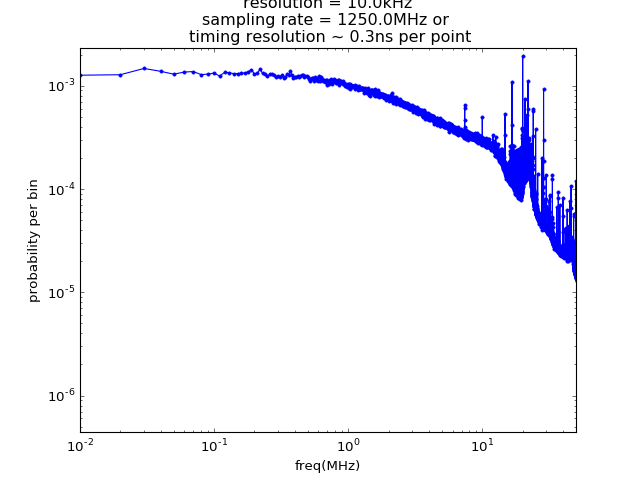

In [61]:
freq,_ = FFT(*hpa.trace_extr(bg_filelist[0]))
plt.figure()
plt.loglog(freq/1e6,probs_mean,marker='.')
plt.xlabel('freq(MHz)')
plt.ylabel('probability per bin')
plt.xlim(0,50)
plt.ylim(0,np.max(probs_mean)*1.2)
plt.title('resolution = {:.1f}kHz\nsampling rate = {:.1f}MHz or \n timing resolution ~ {:.1f}ns per point'.format(np.diff(freq)[0]/1e3, np.max(freq)/1e6, 0.35/np.max(freq)*1e9))

In [29]:
def density(f):
    return np.interp(f,freq,probs_mean)

# Mean FFT from folder of background traces

In [30]:
def bg_fft(bg_filelist,height_th):
    for f in tqdm.tqdm(bg_filelist[:100]):
        t, s = hpa.trace_extr(f)
        if np.max(s) < height_th:
            freq, prob = FFT(t, s)
            probs.append(prob)
    probs_mean=np.nanmean(probs,axis=0)
    freq,_ = FFT(*hpa.trace_extr(bg_filelist[0]))
    return freq, probs_mean

# Comparison of initial and final noise spectrums

In [42]:
# import final noise spectrum
bg_final_folder = '/workspace/projects/TES/data/20170523_TES5_75mK_95uA_trise_115ns/bg_final/'
bg_final_filelist = glob.glob(bg_final_folder+'*.trc')

In [43]:
freq_final, probs_mean_final = bg_fft(bg_final_filelist,0.012)

100%|██████████| 100/100 [00:10<00:00,  9.81it/s]


<IPython.core.display.Javascript object>


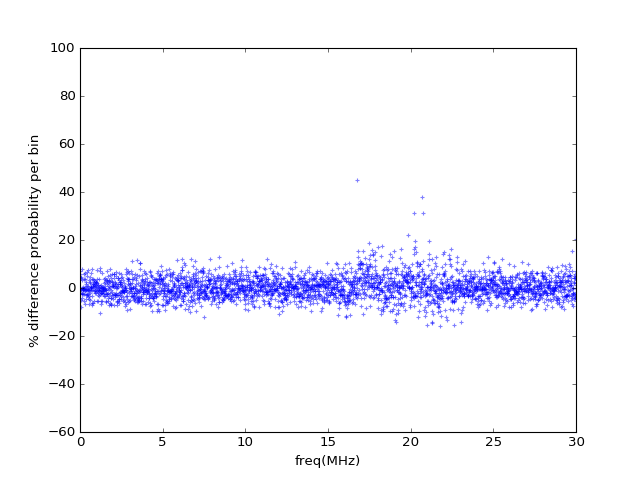

(0, 30)

In [48]:
plt.figure()
# plt.scatter(freq/1e6, probs_mean,
#             marker='.',
#             alpha=0.5,
#            label='initial')
# plt.scatter(freq_final/1e6, probs_mean_final,
#             marker='+',
#             alpha=0.5,
#            label='final')
plt.scatter(freq_final/1e6, (probs_mean_final-probs_mean)*100/probs_mean,
            marker='+',
            alpha=0.5,
           label='difference')
plt.xlabel('freq(MHz)')
plt.ylabel('% difference probability per bin')
plt.xlim(0,30)
# plt.ylim(0,np.max(prob))